### 1- Dataset acquisition 
Dataset link : https://www.kaggle.com/datasets/omkargurav/face-mask-dataset

Contains two classes : Without mask and with mask 

3725 Images of Face with Mask
3828 Images of Face without Mask.




### 2- Training - Sequential Model

In [1]:
##importing modules 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import tensorflow as tf 
import os
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import load_model
from keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
train_dir = "Dataset/Train/"
validation_dir = "Dataset/Validation/"
classes_ = ["Mask","Non Mask"]

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

validation_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2)
validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

Found 5665 images belonging to 2 classes.
Found 1888 images belonging to 2 classes.


In [3]:
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(16,input_shape=(224,224,3), activation='relu', kernel_size=(3,3)),
      tf.keras.layers.AveragePooling2D((2,2)),
      tf.keras.layers.Conv2D(32, activation='relu', kernel_size=(3,3)),
      tf.keras.layers.AveragePooling2D((2,2)),
      tf.keras.layers.Conv2D(64, activation='relu', kernel_size=(3,3)),
      tf.keras.layers.AveragePooling2D((2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
average_pooling2d (AveragePo (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[callback])

c:\Users\srich\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\Users\srich\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
 43/178 [======>.......................] - ETA: 4:30 - loss: 32.5918 - binary_accuracy: 0.6335 - false_negatives: 228.0000

KeyboardInterrupt: 

###  Plotting results (Accuracy and loss)

dict_keys(['loss', 'binary_accuracy', 'false_negatives', 'val_loss', 'val_binary_accuracy', 'val_false_negatives'])


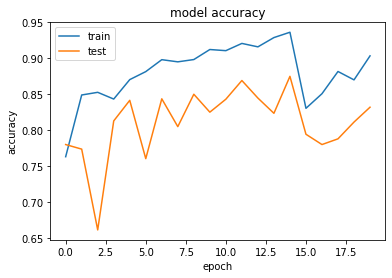

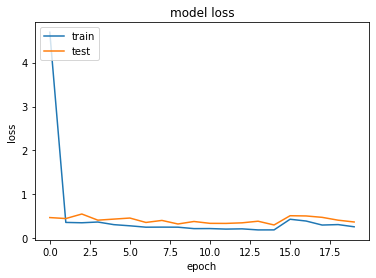

In [ ]:
print(history.history.keys())
# summarize history for accuracy

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

### 3- Testing and evaluating

Confusion Matrix


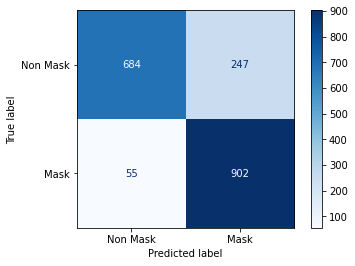

In [ ]:
img_width=224
img_height=224
images = []
for folder in os.listdir(validation_dir):
    folder = os.path.join(validation_dir,folder)
    for img in os.listdir(folder):
        img = os.path.join(folder,img)
        img = image.load_img(img, target_size=(img_width, img_height))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img)
images = np.vstack(images)
classes = model.predict(images, batch_size=10)
y_pred=[]
for i,v in enumerate(classes):
    if (v>0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Mask','Mask'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:

print('Classification Report')
target_names = ['Non Mask','Mask']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Non Mask       0.93      0.73      0.82       931
        Mask       0.79      0.94      0.86       957

    accuracy                           0.84      1888
   macro avg       0.86      0.84      0.84      1888
weighted avg       0.85      0.84      0.84      1888



### 4- Saving trained model

In [ ]:
model_json = model.to_json()
with open("modelseq.json", "w") as json_file:
    json_file.write(model_json)
model.save('fmdseq1.h5')

### Training - VGG16 Model

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [3]:
IMAGE_SIZE = [224, 224]

train_path = 'Dataset/Train'
valid_path = 'Dataset/Validation'

In [4]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [5]:
folders = glob('Dataset/Train/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Dataset/Validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')



Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [7]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

C:\Users\srich\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
19/19 [==============================] - 303s 16s/step - loss: 0.8882 - accuracy: 0.7233 - val_loss: 0.2005 - val_accuracy: 0.9183
Epoch 2/20
19/19 [==============================] - 298s 16s/step - loss: 0.2945 - accuracy: 0.8917 - val_loss: 0.3237 - val_accuracy: 0.8758
Epoch 3/20
19/19 [==============================] - 310s 17s/step - loss: 0.1041 - accuracy: 0.9600 - val_loss: 0.1442 - val_accuracy: 0.9477
Epoch 4/20
19/19 [==============================] - 291s 16s/step - loss: 0.0620 - accuracy: 0.9850 - val_loss: 0.1265 - val_accuracy: 0.9575
Epoch 5/20
19/19 [==============================] - 294s 16s/step - loss: 0.0511 - accuracy: 0.9900 - val_loss: 0.1173 - val_accuracy: 0.9575
Epoch 6/20
19/19 [==============================] - 284s 15s/step - loss: 0.0428 - accuracy: 0.9933 - val_loss: 0.1207 - val_accuracy: 0.9641
Epoch 7/20
19/19 [==============================] - 286s 15s/step - loss: 0.0324 - accuracy: 0.9967 - val_loss: 0.1314 - val_accuracy: 0.9542
Epoch 

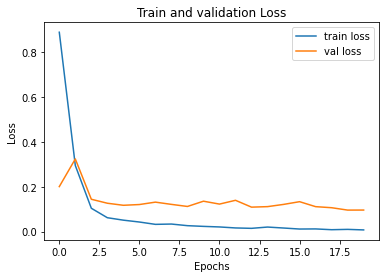

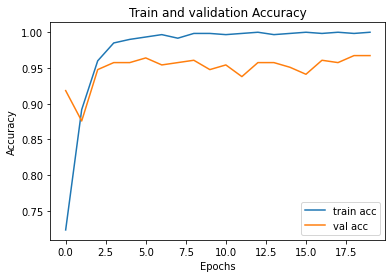

In [10]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Train and validation Loss")
plt.legend()
plt.show()


# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Train and validation Accuracy")
plt.legend()
plt.show()


In [19]:
train_data_dir="Dataset/Train"
test_data_dir="Dataset/Validation"
all_train_imagePaths = list(paths.list_images(train_data_dir))
all_test_imagePaths = list(paths.list_images(test_data_dir))
train_data = []
train_labels = []
test_data = []
test_labels = []

for imagePath in all_train_imagePaths:
# extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

	# update the data and labels lists, respectively
    train_data.append(image)
    train_labels.append(label)
for imagePath in all_test_imagePaths:
# extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))

    image = img_to_array(image)
    image = preprocess_input(image)

	# update the data and labels lists, respectively
    test_data.append(image)
    test_labels.append(label)
    

In [22]:
def convert_data_labels(data,labels):
  #convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels)

  # perform one-hot encoding on the labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)
    return  data,labels
train_data,train_labels = convert_data_labels(train_data,train_labels)
test_data,test_labels = convert_data_labels(test_data,test_labels)
print("Size of train dataset : ",train_data.shape[0])

print("Size of test dataset : ",test_data.shape[0])

Size of train dataset :  600
Size of test dataset :  306


In [23]:
print("[INFO] evaluating network...")
predIdxs = model.predict(test_data, batch_size=32)

predIdxs = np.argmax(predIdxs, axis=1)
val_loss,val_acc = model.evaluate(test_data,test_labels)

print("Accuracy is : ",val_acc)

print("Loss is : ",val_loss)

[INFO] evaluating network...
10/10 [==============================] - 80s 8s/step - loss: 0.1015 - accuracy: 0.9673
Accuracy is :  0.9673202633857727
Loss is :  0.10153726488351822


In [24]:
print(classification_report(test_labels.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       153
           1       0.96      0.98      0.97       153

    accuracy                           0.97       306
   macro avg       0.97      0.97      0.97       306
weighted avg       0.97      0.97      0.97       306



Confusion Matrix


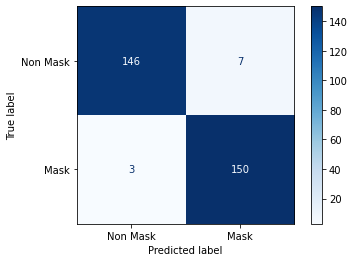

In [25]:
from sklearn.metrics import  confusion_matrix,ConfusionMatrixDisplay
print('Confusion Matrix')
cm = confusion_matrix(test_labels.argmax(axis=1),predIdxs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Mask','Mask'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

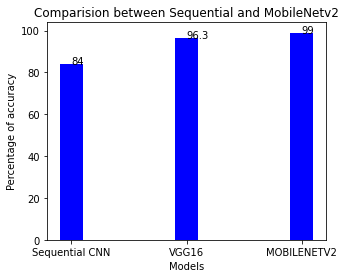

In [2]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'Sequential CNN':84,"VGG16" : 96.3 ,"MOBILENETV2":99}
models = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (5, 4))
for i in range(len(models)):
    plt.text(i,values[i],values[i])
# creating the bar plot
plt.bar(models, values, color ='blue',
        width = 0.2)
 
plt.xlabel("Models")
plt.ylabel("Percentage of accuracy")
plt.title("Comparision between Sequential and MobileNetv2")
plt.show()

In [29]:
model.save('fmdvgg16.h5')

In [46]:
import os
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)



train_data = train_datagen.flow_from_directory(
        'Dataset/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle= True)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('Dataset/Validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [50]:
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None,
                                classifier_activation="relu")

pre_trained_model.load_weights(r'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

for layer in pre_trained_model.layers:
    layer.trainable= True
last_layer= pre_trained_model.get_layer('mixed8')
print(last_layer.output_shape)
last_output= last_layer.output
from tensorflow.keras.optimizers import Adam

#Flatten output layer 1D
x= layers.Flatten()(last_output)

#Fully connected layer
#x= layers.Dense(1024, activation='relu')(x)
x= layers.Dense(1024, activation='relu')(x)

#Dropout due to overfitting
#x= layers.Dropout(0.2)(x)

#Sigmoid for classification
x= layers.Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = Adam(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

(None, 5, 5, 1280)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_564 (Conv2D)             (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 111, 111, 32) 96          conv2d_564[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 111, 111, 32) 0           batch_normalization_564[0][0]    
_________________________________________________________________________

In [51]:
r = model.fit(
  train_data,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(train_data),
  validation_steps=len(test_set)
)

Epoch 1/20
19/19 [==============================] - 186s 9s/step - loss: 11.9479 - accuracy: 0.4833 - val_loss: 1787731139973087232.0000 - val_accuracy: 0.5000
Epoch 2/20
19/19 [==============================] - 183s 10s/step - loss: 1.7270 - accuracy: 0.5017 - val_loss: 1472170557440.0000 - val_accuracy: 0.5000
Epoch 3/20
19/19 [==============================] - 180s 10s/step - loss: 1.0357 - accuracy: 0.4650 - val_loss: 535839680.0000 - val_accuracy: 0.5000
Epoch 4/20
19/19 [==============================] - 181s 10s/step - loss: 0.8408 - accuracy: 0.4883 - val_loss: 4682773.0000 - val_accuracy: 0.5000
Epoch 5/20
19/19 [==============================] - 180s 10s/step - loss: 0.7010 - accuracy: 0.5317 - val_loss: 85501.6484 - val_accuracy: 0.5000
Epoch 6/20
19/19 [==============================] - 180s 9s/step - loss: 0.6928 - accuracy: 0.5150 - val_loss: 1830.4733 - val_accuracy: 0.5000
Epoch 7/20
19/19 [==============================] - 179s 9s/step - loss: 0.6768 - accuracy: 0.5567

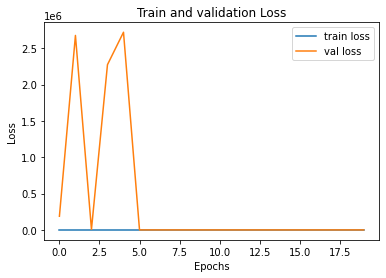

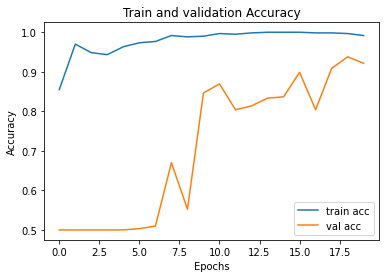

In [49]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Train and validation Loss")
plt.legend()
plt.show()


# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Train and validation Accuracy")
plt.legend()
plt.show()

In [37]:
model.save("inceptionv3.h5")